# Explorative analysis of EN Wikipedia's edit filters

This notebook contains scripts for the analysis and visualisation of some characteristics of the [edit filters](https://en.wikipedia.org/wiki/Wikipedia:Edit_filter) of the English Wikipedia.

In [1]:
import pandas as pd
import itertools
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# set some nicer defaults for matplotlib
from matplotlib import rcParams

We import a cleaned version of manually annotated edit filters:

In [2]:
df = pd.read_csv("20190106115600_filters-sorted-by-hits-manual-tags.csv", sep='\t')

As well as an orignial query against the abuse_filter table:

In [3]:
df_origin = pd.read_csv("quarry-32518-all-filters-sorted-num-hits.csv", sep=',')

And the dataset with the 2nd round of labeling:

In [4]:
df_2nd = pd.read_csv("20190106115600_filters-sorted-by-hits-manual-tags-2nd-round.csv", sep='\t')

## General stats / Filter characteristics

In [90]:
# Number of filters
len(df)

954

In [5]:
# Active (enabled) filters
num_enabled = len(df.query('af_enabled==1'))
print (num_enabled)

# Disabled filters
num_disabled = len(df.query('af_enabled==0'))
print (num_disabled)

# Deleted filters
num_deleted = len(df.query('af_deleted==1'))
print (num_deleted)

# Deleted and enabled -- make sure it's 0 
num_enabled_deleted = len(df.query('af_deleted==1 and af_enabled==1'))
print (num_enabled_deleted)

201
753
600
0


In [6]:
# public filters
num_public = len(df.query('af_hidden==0'))
print (num_public)

# Active public filters
num_enabled_public = len(df.query('af_hidden==0 and af_enabled==1'))
print (num_enabled_public)

# disabled (but not deleted) public filters
num_disabled_public = len(df.query('af_hidden==0 and af_enabled==0 and af_deleted==0'))
print (num_disabled_public)

# deleted public filters
num_deleted_public = num_public - num_enabled_public - num_disabled_public
print (num_deleted_public)

361
110
35
216


In [7]:
# hidden filters
num_hidden = len(df.query('af_hidden==1'))
print (num_hidden)

# active hidden filters
num_enabled_hidden = len(df.query('af_hidden==1 and af_enabled==1'))
print (num_enabled_hidden)

# disabled (but not deleted) hidden filters
num_disabled_hidden = len(df.query('af_hidden==1 and af_enabled==0 and af_deleted==0'))
print (num_disabled_hidden)

# deleted hidden filters
num_deleted_hidden = num_hidden - num_enabled_hidden - num_disabled_hidden
print (num_deleted_hidden)

593
91
118
384


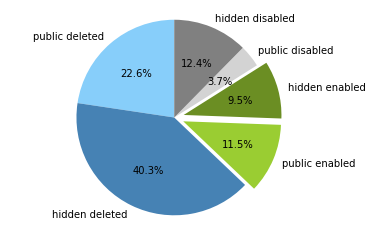

In [17]:
# plot general overview

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
# here, we mean "disabled, but not deleted"
labels = ['public deleted', 'hidden deleted', 'public enabled', 'hidden enabled', 'public disabled', 'hidden disabled']
sizes = [num_deleted_public, num_deleted_hidden, num_enabled_public, num_enabled_hidden, num_disabled_public, num_disabled_hidden]


fig1, ax1 = plt.subplots()
ax1.set_prop_cycle(color=['lightskyblue', 'steelblue', 'yellowgreen', 'olivedrab', 'lightgrey', 'grey'])
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0, 0, 0.1, 0.1, 0, 0), startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.show()

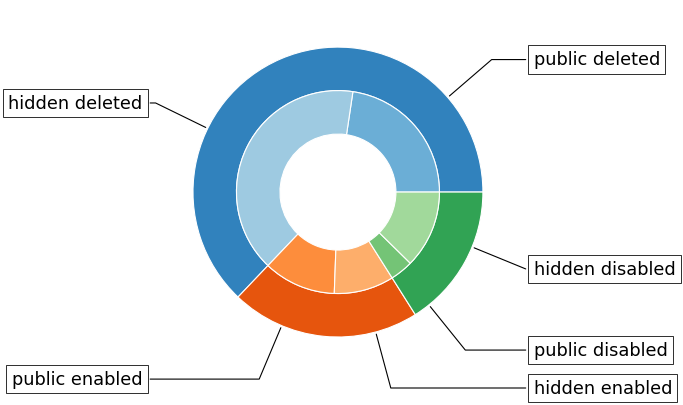

In [16]:
# plot general overview 2nd attempt: group deleted, disabled, enabled

fig, ax = plt.subplots(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

labels = ['public deleted', 'hidden deleted', 'public enabled', 'hidden enabled', 'public disabled', 'hidden disabled']
vals = np.array([[num_deleted_public, num_deleted_hidden], [num_enabled_public, num_enabled_hidden], [num_disabled_public, num_disabled_hidden]])
wedge = 0.3

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors, 
       wedgeprops=dict(width=wedge, edgecolor='w'))

wedges, texts = ax.pie(vals.flatten(), radius=1-wedge, colors=inner_colors,
       wedgeprops=dict(width=wedge, edgecolor='w'))

ax.set(aspect="equal", zorder=0)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=1, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, fontsize=16, **kw)

plt.show()

#fig1, ax1 = plt.subplots()
#ax1.set_prop_cycle(color=['lightskyblue', 'steelblue', 'yellowgreen', 'olivedrab', 'lightgrey', 'grey'])
#ax1.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0, 0, 0.1, 0.1, 0, 0), startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

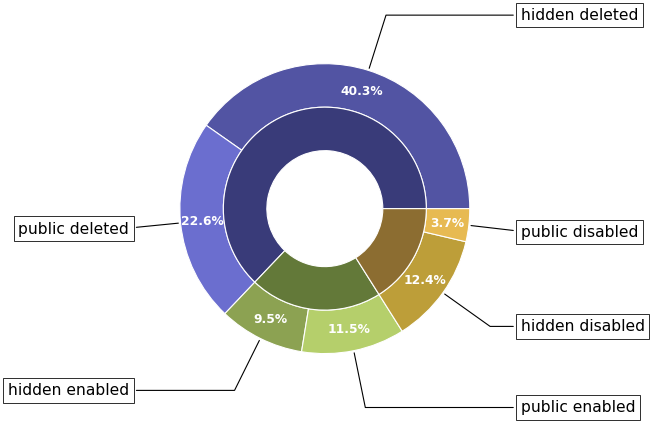

In [24]:
# interchange outer and inner rings

fig, ax = plt.subplots(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

labels = ['hidden deleted', 'public deleted', 'hidden enabled', 'public enabled', 'hidden disabled', 'public disabled']
vals = np.array([[num_deleted_hidden, num_deleted_public], [num_enabled_hidden, num_enabled_public], [num_disabled_hidden, num_disabled_public]])
wedge = 0.3

cmap = plt.get_cmap("tab20b")
inner_colors = cmap(np.arange(3)*4)
outer_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

wedges, _, texts = ax.pie(vals.flatten(), autopct='%1.1f%%', pctdistance=0.85, radius=1, colors=outer_colors, 
       wedgeprops=dict(width=wedge, edgecolor='w'),
       textprops=dict(color='w', fontsize=11, fontweight='demi'))

ax.pie(vals.sum(axis=1), radius=1-wedge, colors=inner_colors,
       wedgeprops=dict(width=wedge, edgecolor='w'))

ax.set(aspect="equal", zorder=0)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=1, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, fontsize=14, **kw)

plt.show()

#fig1, ax1 = plt.subplots()
#ax1.set_prop_cycle(color=['lightskyblue', 'steelblue', 'yellowgreen', 'olivedrab', 'lightgrey', 'grey'])
#ax1.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0, 0, 0.1, 0.1, 0, 0), startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

In [105]:
# not global filters
print (len(df.query('af_global==0')))

954


In [5]:
# throttled -- not sure what this flag means
print (len(df.query('af_throttled==0')))

print (len(df.query('af_throttled==1')))

948
6


In [9]:
# group
print (len(df.query('af_group=="default"')))
print (df.query('af_group!="default"'))

# --> so available groups are "default" and "feedback"
# TODO: question: what do they mean?
# From https://www.mediawiki.org/wiki/Extension:AbuseFilter/abuse_filter_table :
# "The group this filter belongs to, as defined in $wgAbuseFilterValidGroups." still don't get it
'''
Feedback seems to be a legacy thing from a plugin which was supposed to collect readers feedback on articles.
It wasn't deemed useful enough though and was eventually turned off.
All the filters that referred to it are in the meantime marked as deleted.
'''

947
     Unnamed: 0  af_id  af_hidden  af_global  af_enabled  af_deleted  \
168         168    497          0          0           0           1   
173         173    494          0          0           0           1   
174         174    502          0          0           0           1   
187         187    495          0          0           0           1   
190         190    496          0          0           0           1   
227         227    475          0          0           0           1   
349         349    461          0          0           0           1   

     af_throttled  af_group    af_timestamp af_actions  af_hit_count  \
168             0  feedback  20130108151106   disallow          3660   
173             0  feedback  20130108151035   disallow          3325   
174             0  feedback  20130424011002   disallow          3280   
187             0  feedback  20130108151045   disallow          2697   
190             0  feedback  20130108151054   disallow     

### Timestamp: When were filters last modified?

Have a lot of filters been modified for the last time recently?

In [44]:
df_origin['af_timestamp'] = pd.to_datetime(df_origin['af_timestamp'], format="%Y%m%d%H%M%S")

#df_modified = df_origin['af_timestamp'].groupby([df_origin.af_timestamp.dt.to_period("M")]).agg('count')
#df_modified
df_modified = df_origin.set_index('af_timestamp').resample("M").size()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print (df_modified)

af_timestamp
2009-03-31    29
2009-04-30    19
2009-05-31    11
2009-06-30     8
2009-07-31     8
2009-08-31    21
2009-09-30    21
2009-10-31     6
2009-11-30    13
2009-12-31     3
2010-01-31     9
2010-02-28     9
2010-03-31    10
2010-04-30     5
2010-05-31     5
2010-06-30     1
2010-07-31     0
2010-08-31    10
2010-09-30     5
2010-10-31     0
2010-11-30     4
2010-12-31     1
2011-01-31     2
2011-02-28     0
2011-03-31    23
2011-04-30     2
2011-05-31     3
2011-06-30     1
2011-07-31     0
2011-08-31     2
2011-09-30     1
2011-10-31     0
2011-11-30     1
2011-12-31     0
2012-01-31     0
2012-02-29    10
2012-03-31     0
2012-04-30     0
2012-05-31     0
2012-06-30     1
2012-07-31     1
2012-08-31    36
2012-09-30     2
2012-10-31     1
2012-11-30     1
2012-12-31     2
2013-01-31     4
2013-02-28     1
2013-03-31     2
2013-04-30    21
2013-05-31     0
2013-06-30     1
2013-07-31     2
2013-08-31     0
2013-09-30     0
2013-10-31     2
2013-11-30     0
2013-12-31     0
2

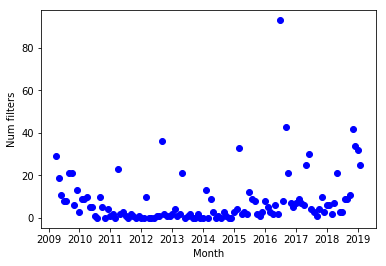

In [41]:
plt.xlabel('Month')
plt.ylabel('Num filters')
plt.plot(df_modified, 'bo')
plt.show()

It is noticeable that quite some filters were last modified in June 2016 (93 filters). Potentially, a lot more filters were modified at this time and also modified later again.
An inquiry into the filters history (https://en.wikipedia.org/wiki/Special:AbuseFilter/history?user=&filter=669) shows that an edit filter manager did a big cleanup and (mostly) deleted stale filters.
All of this doesn't seem to be particularly exciting or worth discussing though.

### Helper functions

In [7]:
flatten = lambda x: list(itertools.chain.from_iterable(x))

### Edit filter actions

In [8]:
actions = df['af_actions'].fillna('log only')
actions_list = flatten([x.split(",") for x in list(actions)])
all_actions = collections.Counter(actions_list).most_common()

print(all_actions)

[('log only', 413), ('disallow', 406), ('warn', 122), ('tag', 70), ('throttle', 52), ('blockautopromote', 4)]


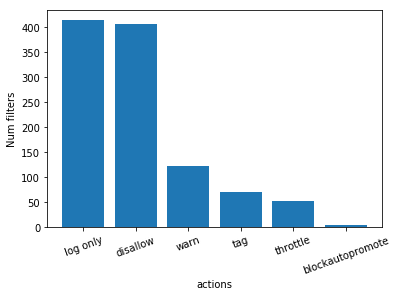

In [12]:
all_actions_labels = [x[0] for x in all_actions]
all_actions_values = [x[1] for x in all_actions]

plt.xlabel('actions')
plt.xticks(rotation='20')
plt.ylabel('Num filters')
plt.bar(all_actions_labels, all_actions_values)
plt.show()

This diagram depicts all filters. 2/3 of them are deleted/disabled. Often, before a filter is disabled all its actions but "log" are deactivated. So it makes sense the diagram shows a lot of "log only" actions.

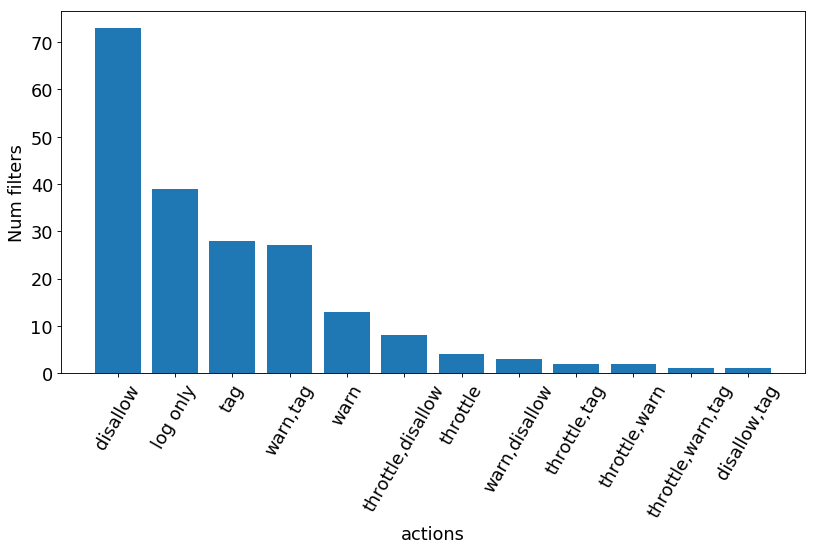

In [20]:
# What are the actions of all active filters
active = df.query('af_enabled==1')
active_actions = collections.Counter(list(active['af_actions'].fillna('log only'))).most_common()

active_labels = [x[0] for x in active_actions]
active_values = [x[1] for x in active_actions]

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

plt.xlabel('actions', fontsize=16)
plt.xticks(rotation='60', fontsize=16)
plt.ylabel('Num filters', fontsize=16)
plt.yticks(fontsize=16)
plt.bar(active_labels, active_values)
plt.show()

In [11]:
# What are the actions of active hidden filters
active_hidden = df.query('af_hidden==1 and af_enabled==1')
active_hidden_actions = collections.Counter(list(active_hidden['af_actions'].fillna('log only'))).most_common()
print (active_hidden_actions)

[('disallow', 51), ('log only', 19), ('throttle,disallow', 7), ('throttle', 4), ('tag', 3), ('warn,tag', 2), ('throttle,warn', 2), ('warn', 1), ('disallow,tag', 1), ('warn,disallow', 1)]


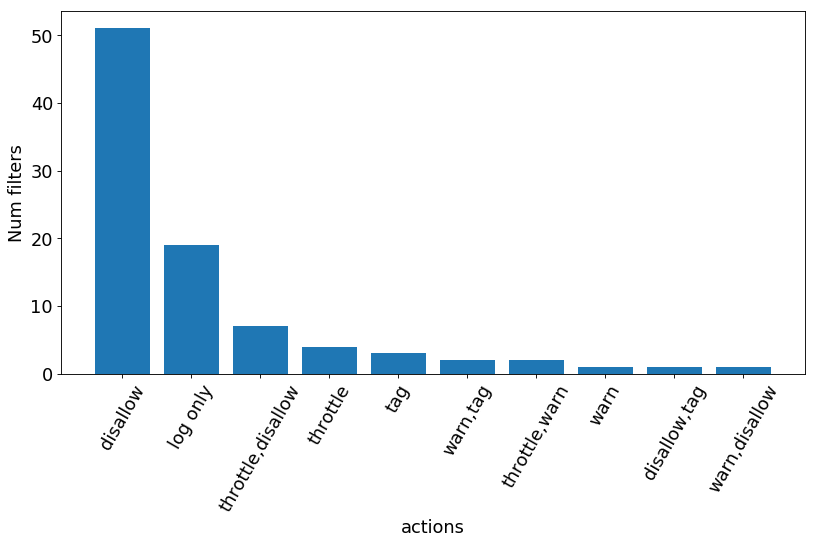

In [19]:
ah_actions_labels = [x[0] for x in active_hidden_actions]
ah_actions_values = [x[1] for x in active_hidden_actions]

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('actions', fontsize=16)
plt.xticks(rotation='60',fontsize=16)
plt.ylabel('Num filters',fontsize=16)
plt.yticks(fontsize=16)
plt.bar(ah_actions_labels, ah_actions_values)
plt.show()

In [14]:
# What are the actions of active public filters
active_public = df.query('af_hidden==0 and af_enabled==1')
active_public_actions = collections.Counter(list(active_public['af_actions'].fillna('log only'))).most_common()
print(active_public_actions)

[('tag', 25), ('warn,tag', 25), ('disallow', 22), ('log only', 20), ('warn', 12), ('throttle,tag', 2), ('warn,disallow', 2), ('throttle,warn,tag', 1), ('throttle,disallow', 1)]


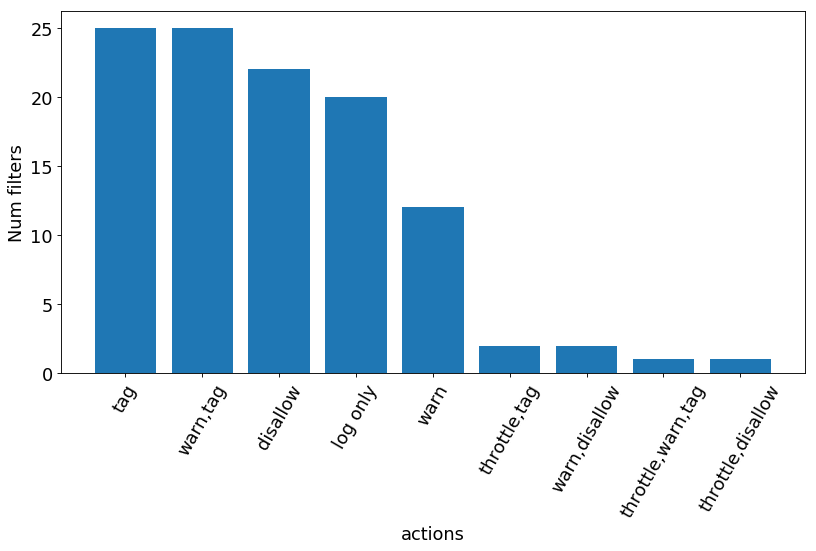

In [18]:
ap_actions_labels = [x[0] for x in active_public_actions]
ap_actions_values = [x[1] for x in active_public_actions]

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('actions', fontsize=16)
plt.xticks(rotation='60', fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Num filters', fontsize=16)
plt.bar(ap_actions_labels, ap_actions_values)
plt.show()

In [18]:
# all ids of active public filters set to disallow
active_public[active_public['af_actions'].fillna('log only').str.contains('disallow')]

,Unnamed: 0,af_id,af_hidden,af_global,af_enabled,af_deleted,af_throttled,af_group,af_timestamp,af_actions,af_hit_count,af_public_comments,manual_tags,notes
3,3,384,0,0,1,0,0,default,20181018171832,disallow,1159239,Addition of bad words or other vandalism,vandalism,NaN
12,12,225,0,0,1,0,0,default,20180807154519,disallow,482872,Vandalism in all caps,vandalism,NaN
19,19,46,0,0,1,0,0,default,20181023193500,disallow,356945,"""Poop"" vandalism",vandalism,NaN
22,22,260,0,0,1,0,0,default,20181130204255,disallow,286852,Common vandal phrases,vandalism,NaN
37,37,320,0,0,1,0,0,default,20181023193636,disallow,152994,"""Your mom"" Vandalism",vandalism,NaN
41,41,12,0,0,1,0,0,default,20170606215509,disallow,122756,Replacing a page with obscenities,vandalism,NaN
47,47,680,0,0,1,0,0,default,20181023195329,disallow,95242,Adding emoji unicode characters,good_faith,NaN
54,54,365,0,0,1,0,0,default,20181023193820,disallow,85470,Unusual changes to featured or good content,vandalism,Unusual == unusually big (edit_delta > 15000 |...
67,67,803,0,0,1,0,0,default,20181023223916,disallow,46756,Prevent new users from editing other's user pages,"vandalism, good_faith",NaN
99,99,782,0,0,1,0,0,default,20181023223745,disallow,16702,Content Translation Edits,misc,why is this not allowed? Seems to be translati...


## Filter activity

### Hit count

In [69]:
 df['af_hit_count'].describe()

count    9.540000e+02
mean     2.401892e+04
std      1.205649e+05
min      0.000000e+00
25%      7.000000e+00
50%      9.050000e+01
75%      1.185250e+03
max      1.611956e+06
Name: af_hit_count, dtype: float64

### Filter hits over the years

In [6]:
df_hits = pd.read_csv("quarry-34014-how-many-abuse-filter-hits-have-been-there-per-month-en-wiki-run346197.csv", sep=',')
df_hits['LogMonth'] = pd.to_datetime(df_hits['LogMonth'], format="%Y%m")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_hits)


      LogMonth    Freq
0   2019-03-01   34309
1   2019-02-01  236606
2   2019-01-01  252668
3   2018-12-01  226287
4   2018-11-01  253233
5   2018-10-01  256438
6   2018-09-01  230354
7   2018-08-01  216045
8   2018-07-01  205477
9   2018-06-01  209374
10  2018-05-01  238235
11  2018-04-01  242857
12  2018-03-01  255431
13  2018-02-01  213548
14  2018-01-01  235705
15  2017-12-01  213359
16  2017-11-01  254671
17  2017-10-01  224244
18  2017-09-01  212790
19  2017-08-01  195593
20  2017-07-01  176778
21  2017-06-01  184406
22  2017-05-01  231250
23  2017-04-01  225176
24  2017-03-01  257081
25  2017-02-01  246199
26  2017-01-01  256925
27  2016-12-01  226680
28  2016-11-01  258655
29  2016-10-01  254070
30  2016-09-01  238406
31  2016-08-01  192681
32  2016-07-01  171567
33  2016-06-01  201867
34  2016-05-01  294276
35  2016-04-01  319474
36  2016-03-01  360327
37  2016-02-01  366637
38  2016-01-01  372907
39  2015-12-01  307003
40  2015-11-01  338129
41  2015-10-01  264966
42  2015-09

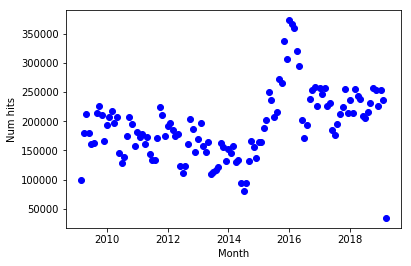

In [9]:
plt.xlabel('Month')
plt.ylabel('Num hits')
plt.plot(df_hits['LogMonth'],df_hits['Freq'], 'bo')
plt.show()

#TODO: why is the peak there? there's an upward tendency

Data quarry from 05.03.2019, that's why hitcount Mar 2019 is so small.
Mar 2009 is also lower, since the first filter was introduced on 17.3.2009 and not at the beginning of the month.

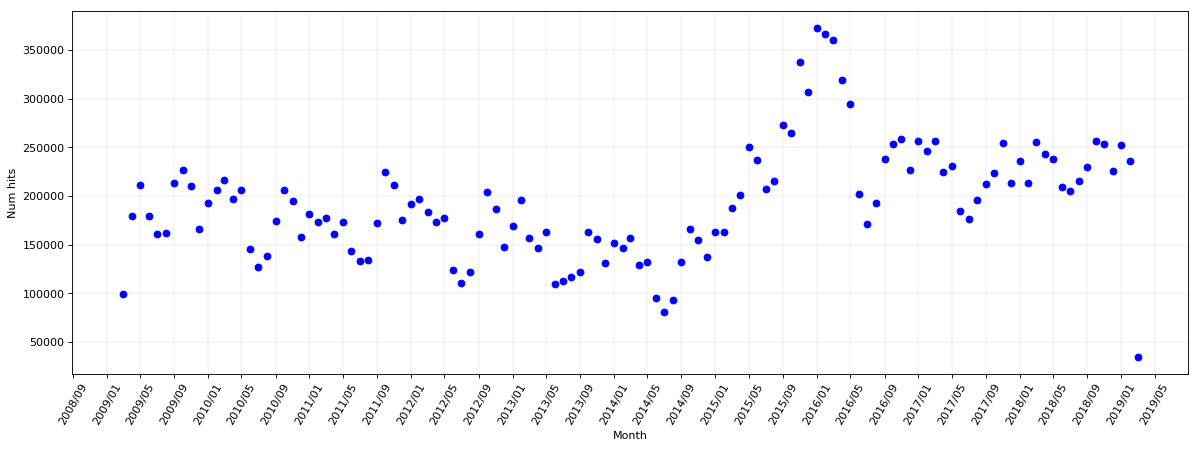

In [40]:
# The same plot as above, but "zoomed in", so we can actually read the values for single months
fig, ax = plt.subplots(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')

xfmt = matplotlib.dates.DateFormatter('%Y/%m')
ax.xaxis.set_major_formatter(xfmt)

locator = matplotlib.dates.MonthLocator(bymonth=[1,5,9])
ax.xaxis.set_major_locator(locator)

plt.xlabel('Month')
plt.ylabel('Num hits')
plt.plot_date(df_hits['LogMonth'],df_hits['Freq'], 'bo')
#plt.xticks(matplotlib.dates.date2num(df_hits['LogMonth']))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 60)
plt.grid(color='0.7', linestyle='-', linewidth=0.2)
plt.show()

#### Explore the peak in filter hits

In [6]:
df_jan2016 = pd.read_csv("quarry-37494-abuselog-entries-en-wiki-in-january-2016-run389216.csv", sep=',')

# Number of hits per editor
df_jan2016['afl_user_text'].value_counts() #TODO intersect users with actions/pages

10.68.16.39                                1689
37.113.52.15                               1249
95.152.44.52                               1133
5.165.178.194                               715
94.181.143.10                               697
95.152.42.158                               674
5.166.250.109                               559
5.166.224.152                               556
Acheter cialis                              533
37.113.51.96                                473
93.124.7.25                                 430
5.167.114.39                                317
93.124.34.23                                307
36.250.176.0                                291
Wwekik2222kdjdj                             279
37.113.37.111                               274
94.181.170.143                              247
Theadityapratap                             239
94.181.156.128                              229
Achat cialis                                222
93.124.46.78                            

37.113.52.15 is a Russian IP (whois --> netname:        ERTH-PENZA-PPPOE-16-NET)
95.152.44.52 too (whois--> netname:        RU-PENZA-VT-DSL-200901)

In [10]:
# Try to intersect users with actions/pages
grouped = df_jan2016.groupby(['afl_user_text','afl_action']).size().reset_index()
grouped.sort_index(ascending=False)

,afl_user_text,afl_action,0
141604,ﾠﾠﾠﾠﾠﾠﾠﾠﾠ,createaccount,1
141603,ﾠﾠﾠ,createaccount,1
141602,ＲＩＥＡＫＩ,edit,1
141601,해림김수진,edit,2
141600,타설현황,edit,2
141599,지드라공,createaccount,2
141598,지드라곤,createaccount,3
141597,이강민2,createaccount,2
141596,박강준,createaccount,2
141595,鹿晗7,createaccount,3


In [51]:
# What were the very active IPs doing
df_jan2016[df_jan2016['afl_user_text'] == '10.68.16.39']

,afl_id,afl_filter,afl_user,afl_user_text,afl_ip,afl_action,afl_actions,afl_var_dump,afl_timestamp,afl_namespace,afl_title,afl_wiki,afl_deleted,afl_patrolled_by,afl_rev_id,afl_log_id
206541,14364756,80,0,10.68.16.39,NaN,edit,warn,stored-text:707056949,20160119015147,0,Eric_Gordon,NaN,0,0,NaN,NaN
206547,14364762,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057055,20160119015250,0,Members_of_the_111th_United_States_Congress,NaN,0,0,NaN,NaN
206553,14364768,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057079,20160119015300,0,"Greenon_High_School_(Springfield,_Ohio)",NaN,0,0,NaN,NaN
206564,14364779,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057104,20160119015316,0,Maggie_Anderson,NaN,0,0,NaN,NaN
206565,14364780,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057139,20160119015330,0,Josh_Blackie,NaN,0,0,NaN,NaN
206568,14364783,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057194,20160119015402,0,Tenacious_D_discography,NaN,0,0,NaN,NaN
206601,14364816,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057523,20160119015652,0,Operation_Pawan,NaN,0,0,NaN,NaN
206602,14364817,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057586,20160119015720,0,"Catholic_Central_School_(Springfield,_Ohio)",NaN,0,0,NaN,NaN
206603,14364818,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057636,20160119015740,0,Dane_Richards,NaN,0,0,NaN,NaN
206610,14364825,80,0,10.68.16.39,NaN,edit,warn,stored-text:707057791,20160119015852,0,Milford_High_School_(Ohio),NaN,0,0,NaN,NaN


Edit filter ID 80 is called "link spam". So this user appears to probably have entirely hit filter 80 the whole time. Interestingly enough though, when clicking randomly through the diffs of the user's edits, they don't seem to be (conventional) spam: except that most of them are creating archive.org links, the pages that they are actually snapshotting look like ones that really have something to do with the topic. Unless there's a policy against the wayback machine and/or it's often misused for spamming. Filter 80 only checks whether more links were added than references though.

In [52]:
# What were the very active IPs doing
df_jan2016[df_jan2016['afl_user_text'] == '37.113.52.15']

,afl_id,afl_filter,afl_user,afl_user_text,afl_ip,afl_action,afl_actions,afl_var_dump,afl_timestamp,afl_namespace,afl_title,afl_wiki,afl_deleted,afl_patrolled_by,afl_rev_id,afl_log_id
50629,14208834,271,0,37.113.52.15,NaN,edit,warn,stored-text:704885530,20160106073655,11,Africa_topic,NaN,0,0,NaN,NaN
50630,14208835,466,0,37.113.52.15,NaN,edit,warn,stored-text:704885530,20160106073655,11,Africa_topic,NaN,0,0,NaN,NaN
50631,14208836,271,0,37.113.52.15,NaN,edit,warn,stored-text:704885531,20160106073656,11,Africa_topic,NaN,0,0,NaN,NaN
50632,14208837,466,0,37.113.52.15,NaN,edit,warn,stored-text:704885531,20160106073656,11,Africa_topic,NaN,0,0,NaN,NaN
50633,14208838,271,0,37.113.52.15,NaN,edit,warn,stored-text:704885534,20160106073657,11,Africa_topic,NaN,0,0,NaN,NaN
50634,14208839,466,0,37.113.52.15,NaN,edit,warn,stored-text:704885534,20160106073657,11,Africa_topic,NaN,0,0,NaN,NaN
50635,14208840,271,0,37.113.52.15,NaN,edit,warn,stored-text:704885535,20160106073657,11,Africa_topic,NaN,0,0,NaN,NaN
50636,14208841,279,0,37.113.52.15,NaN,edit,tag,stored-text:704885535,20160106073657,11,Africa_topic,NaN,0,0,NaN,NaN
50637,14208842,466,0,37.113.52.15,NaN,edit,warn,stored-text:704885535,20160106073657,11,Africa_topic,NaN,0,0,NaN,NaN
50638,14208843,271,0,37.113.52.15,NaN,edit,warn,stored-text:704885536,20160106073657,11,Africa_topic,NaN,0,0,NaN,NaN


This one has triggered very frequently (at least from thead and tail) filters 271, 279 and 466, all hidden:
271 "Possible spambot"
279 "Repeated attempts to vandalize"
466 "Userspace & talk page spamming"

The thing is, we cannot view the diffs for the intended edits for hidden filters (since this would make filter pattern easily guessable). So we don't know what a lot of these intended edits were.

We can have a look at a couple of edits that triggered public filters such as
30 "Large deletion from article by new editors"
80 "Link spamming"
220 "Adding external images/links"

All the diffs I looked at looked exactly the same and were obvious spam (viagra websites, etc).
I'd say this was a spambot.

In [53]:
# What were the very active IPs doing
df_jan2016[df_jan2016['afl_user_text'] == '95.152.44.52']

,afl_id,afl_filter,afl_user,afl_user_text,afl_ip,afl_action,afl_actions,afl_var_dump,afl_timestamp,afl_namespace,afl_title,afl_wiki,afl_deleted,afl_patrolled_by,afl_rev_id,afl_log_id
252411,14410640,271,0,95.152.44.52,NaN,edit,warn,stored-text:707617359,20160122071743,11,WikiProject_Physics,NaN,0,0,NaN,NaN
252412,14410641,466,0,95.152.44.52,NaN,edit,warn,stored-text:707617359,20160122071743,11,WikiProject_Physics,NaN,0,0,NaN,NaN
252426,14410655,466,0,95.152.44.52,NaN,edit,warn,stored-text:707617417,20160122071827,1,Nirvana,NaN,0,0,NaN,NaN
252435,14410664,30,0,95.152.44.52,NaN,edit,warn,stored-text:707617482,20160122071906,0,District_health_board,NaN,0,0,NaN,NaN
252436,14410665,220,0,95.152.44.52,NaN,edit,warn,stored-text:707617482,20160122071906,0,District_health_board,NaN,0,0,NaN,NaN
252437,14410666,271,0,95.152.44.52,NaN,edit,warn,stored-text:707617482,20160122071906,0,District_health_board,NaN,0,0,NaN,NaN
252442,14410671,466,0,95.152.44.52,NaN,edit,warn,stored-text:707617536,20160122071939,1,Liberal_arts_education,NaN,0,0,NaN,NaN
252451,14410680,132,0,95.152.44.52,NaN,edit,warn,stored-text:707617701,20160122072124,0,Tamil_Nadu_Pollution_Control_Board,NaN,0,0,NaN,NaN
252452,14410681,220,0,95.152.44.52,NaN,edit,warn,stored-text:707617701,20160122072124,0,Tamil_Nadu_Pollution_Control_Board,NaN,0,0,NaN,NaN
252453,14410682,271,0,95.152.44.52,NaN,edit,warn,stored-text:707617701,20160122072124,0,Tamil_Nadu_Pollution_Control_Board,NaN,0,0,NaN,NaN


A lot of triggers of
466 "Userspace & talk page spamming"
271 "Possible spambot"

Following 2 diffs https://en.wikipedia.org/wiki/Special:AbuseLog/14413885 and https://en.wikipedia.org/wiki/Special:AbuseLog/14413886
reveal it's the exact same spambot operating from another IP (which seems to belong to the same russian provider)

In [43]:
# Number of hits per editor's actions
df_jan2016['afl_action'].value_counts()

edit                 300781
createaccount         71902
move                    193
autocreateaccount        18
gatheredit                9
delete                    4
Name: afl_action, dtype: int64

In [7]:
# Number of hits per filter
df_jan2016['afl_filter'].value_counts().describe()

count      138.000000
mean      2702.224638
std       7454.825274
min          1.000000
25%         25.250000
50%        250.500000
75%       2799.000000
max      71853.000000
Name: afl_filter, dtype: float64

In [45]:
# Number of hits per intended edit page
df_jan2016['afl_title'].value_counts()

UserLogin                                                                                                                                          71920
Skateboard                                                                                                                                           660
Conchobar_Lads_Tomlinson                                                                                                                             584
Billboard_(magazine)                                                                                                                                 536
Chris_Stark                                                                                                                                          467
Tyler_Joseph                                                                                                                                         431
Bulletin_board_system                                                             

To be fair, I don't see any particularly interesting or conspicious pattern, beside the 71920 attempts at account creations. Neither the pages edited are extraordinary, nor are there particular pages with extra-orbitant hits; users are not particularly interesting either and it's mostly the most active filters that got triggered anyway.

The 3 IP editors with +1000 filter triggers triggered above all (or maybe exclusively) filters dealing with linkspam.

But maybe it's exactly them that make the 71920 hits difference to all the "standard" numbers. I'm comparing this with September 2016 (238406 hits) for reference.

#### Filter hits in September 2016

In [8]:
df_sep2016 = pd.read_csv("quarry-37496-abuselog-entries-en-wiki-in-september-2016-run389243.csv", sep=',')

# Number of hits per editor's actions
df_sep2016['afl_action'].value_counts()

edit                 213279
createaccount         24824
move                    196
autocreateaccount        88
delete                   19
Name: afl_action, dtype: int64

In [10]:
df_sep2016['afl_filter'].value_counts()

527    24743
61     21609
384    18895
633    16897
650    16766
636    15372
135     8195
172     6582
3       5206
432     5005
380     4814
30      4801
712     4520
364     4519
686     4370
260     3342
279     3324
189     3103
231     3059
784     2893
98      2794
50      2745
550     2696
225     2667
631     2602
491     2317
752     2291
46      2223
132     2215
680     2053
       ...  
68        17
770       17
345       17
751       16
224       15
744       14
167       13
781       11
723       11
745       10
2          9
755        9
624        7
242        6
762        6
722        6
667        5
651        5
642        5
694        4
792        4
734        3
757        3
710        2
795        1
294        1
690        1
743        1
1          1
639        1
Name: afl_filter, Length: 139, dtype: int64

In [9]:
# Number of hits per filter
df_sep2016['afl_filter'].value_counts().describe()

count      139.000000
mean      1715.151079
std       4035.023411
min          1.000000
25%         25.500000
50%        231.000000
75%       1714.500000
max      24743.000000
Name: afl_filter, dtype: float64

Mh. The comparison is not really insightful. It's just a proportionally smaller numbers of all actions. That's not exactly true though. The edits ration is 2/3, whereas the createaccount ration is 1/3 (3 being the Jan values)

In [48]:
# Number of hits per editor
df_sep2016['afl_user_text'].value_counts() #TODO intersect users with actions/pages

89.178.207.116                             495
98.206.72.9                                207
Erwewer7                                   182
209.93.158.179                             154
PCSO Bethany Slaughter                     136
GoldRingChip                               110
191.176.114.155                             95
2001:56A:F655:EE00:D04F:9F13:A37A:E2A       93
DY3o!                                       92
84.236.56.77                                91
Sdfghuykiujhgf                              87
Safdfhgjusasssss                            87
184.184.116.211                             86
Asdfghjkjhgfdsdfgh                          85
Junior5a is Queer                           82
Werldwayd                                   81
PanchoS                                     80
107.77.219.67                               78
192.43.223.44                               76
DIo.cixia                                   76
24.130.207.26                               75
2604:2D80:C02

The comparison of number of edits per user reveals that in January there were a couple of particularly active IPs. It would be interesting to know what they were trying to do. (Answer: they were spamming.)

#### Filter hits Februrary 2016

In [34]:
df_feb2016 = pd.read_csv("quarry-37514-abuselog-entries-en-wiki-in-february-2016-run389412.csv", sep=',')

# Number of hits per editor's actions
df_feb2016['afl_action'].value_counts()

edit                 298610
createaccount         67721
move                    282
gatheredit               18
autocreateaccount         5
delete                    1
Name: afl_action, dtype: int64

Again, quite a high createaccount counts..

In [36]:
# Number of hits per intended edit page
df_feb2016['afl_title'].value_counts()

UserLogin                                        67726
Bob_Ezrin                                          816
Billboard_(magazine)                               576
WikiProject_Film                                   404
Bulletin_board_system                              362
Skateboard                                         334
Board_game                                         249
Randy_Gardner_(record_holder)                      234
Computer_keyboard                                  186
Tripoli_under_Italian_rule                         163
Snowboarding                                       137
Rameez_Raja                                        136
British_Board_of_Film_Classification               133
Reserve_Forces_Policy_Board                        131
Undertale                                          128
Nadeshot                                           127
Carolina_Panthers                                  122
The_Life_of_Pablo                                  116
Achinoam_N

In [37]:
# Number of hits per editor
df_feb2016['afl_user_text'].value_counts() #TODO intersect users with actions/pages

95.152.10.186            920
37.113.42.202            707
5.166.253.56             336
RichardEi                286
Achat cialis             241
46.188.71.226            236
93.124.87.217            212
176.212.131.244          201
5.167.191.123            197
95.152.49.234            191
95.152.40.97             178
94.181.143.54            176
95.152.9.227             169
Prix cialis              166
Acheter cialis           157
41.225.84.56             155
46.118.114.195           149
Elisa314                 146
93.124.114.195           145
Brightgalrs              144
125.238.47.82            144
95.152.32.236            143
5.167.177.64             137
93.124.107.61            136
109.162.125.254          131
AlButch                  128
93.124.42.25             127
84.90.219.128            123
95.152.15.40             117
117.68.217.44            117
                        ... 
CinnamonFishbackCMxls      1
5.103.226.148              1
Shalom Delmar              1
40.134.150.205

An inquiry into 95.152.10.186's edits shows, it's same viagra spam as in January. Some of the top named accounts: "Prix cialis" ,"Acheter cialis" and "Achat cialis" sound very similar to the viagra spam domains, so it's probably socks of the same thing

#### Filter hits March 2016

In [38]:
df_mar2016 = pd.read_csv("quarry-37515-abuselog-entries-en-wiki-in-march-2016-run389414.csv", sep=',')

# Number of hits per editor's actions
df_mar2016['afl_action'].value_counts()

edit                 308138
createaccount         51812
move                    352
autocreateaccount        23
delete                    2
Name: afl_action, dtype: int64

Again, quite a high createaccount counts..

In [39]:
# Number of hits per intended edit page
df_mar2016['afl_title'].value_counts()

UserLogin                                           51835
209.236.119.231                                      2221
Skateboard                                            718
Billboard_(magazine)                                  629
WikiProject_Film                                      592
Bulletin_board_system                                 561
Jason_Rothenberg_(television_producer)                501
Snowboarding                                          435
Board_game                                            387
Reserve_Forces_Policy_Board                           355
British_Board_of_Film_Classification                  334
Dvorak_Simplified_Keyboard                            327
UFC_196                                               270
WikiProject_India                                     239
Computer_keyboard                                     228
Sandbox                                               223
Board_of_directors                                    197
Josh_Boden    

In [40]:
# Number of hits per editor
df_mar2016['afl_user_text'].value_counts() #TODO intersect users with actions/pages

89.178.195.212                        2928
209.236.119.231                       2225
93.124.100.71                         1101
RichardEi                              529
176.213.105.10                         487
Acheter viagra                         476
95.152.29.103                          379
Achat viagra                           376
95.152.37.178                          358
95.152.4.24                            327
94.181.137.245                         309
95.152.57.6                            308
5.166.246.166                          299
37.113.22.196                          271
110.89.8.214                           259
37.113.26.96                           257
95.152.20.130                          257
178.137.160.82                         245
37.113.37.4                            242
65.128.133.116                         234
95.152.8.13                            223
95.152.34.153                          222
110.89.17.186                          218
93.124.84.9

Ui,89.178.195.212 is something new: oxycothyn paragraphs instead of viagra links.. And RichardEi lässt grüßen

### Actions over the years

The purpose of the next snippet is to comprehend whether there is/was a tendency towards more liberal or stricter actions.

In [6]:
# Which actions were triggered how often over the years
df_actions = pd.read_csv("quarry-34047-number-of-abuse-filters-filter-actions-per-month-en-wiki-run346492.csv", sep=',')
df_actions['LogMonth'] = pd.to_datetime(df_actions['LogMonth'], format="%Y%m")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_actions.fillna('log only'))

      LogMonth         FilterActions    Freq
0   2019-03-01              log only   14103
1   2019-03-01              disallow    9430
2   2019-03-01                   tag   13283
3   2019-03-01                  warn    6001
4   2019-02-01              log only   73101
5   2019-02-01              disallow   47242
6   2019-02-01          disallow,tag       8
7   2019-02-01                   tag   81279
8   2019-02-01                  warn   34976
9   2019-01-01              log only   81745
10  2019-01-01              disallow   44370
11  2019-01-01          disallow,tag       8
12  2019-01-01                   tag   89263
13  2019-01-01                  warn   37282
14  2018-12-01              log only   83958
15  2018-12-01              disallow   33417
16  2018-12-01          disallow,tag       6
17  2018-12-01                   tag   76257
18  2018-12-01                  warn   32649
19  2018-11-01              log only   83866
20  2018-11-01              disallow   43244
21  2018-1

A per month break-down is difficult to plot on DIN A4 paper (maybe?); I'm aggregating them per year to start.

In [12]:
# Which actions were triggered how often over the years
df_actions_year = pd.read_csv("quarry-37500-number-of-abuse-filters-filter-actions-per-year-en-wiki-run389252.csv", sep=',')
df_actions_year['LogYear'] = pd.to_datetime(df_actions_year['LogYear'], format="%Y")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df_actions_year.fillna('log only'))

      LogYear         FilterActions     Freq
0  2019-01-01              log only   498557
1  2019-01-01              disallow   312772
2  2019-01-01          disallow,tag       18
3  2019-01-01                   tag   473854
4  2019-01-01                  warn   205715
5  2018-01-01              log only  1019817
6  2018-01-01              disallow   366209
7  2018-01-01          disallow,tag       71
8  2018-01-01                   tag   944445
9  2018-01-01                  warn   452407
10 2017-01-01              log only   727988
11 2017-01-01              disallow   395566
12 2017-01-01          disallow,tag      961
13 2017-01-01                   tag  1057178
14 2017-01-01                  warn   496777
15 2016-01-01              log only  1188795
16 2016-01-01              disallow   397976
17 2016-01-01          disallow,tag    27752
18 2016-01-01                   tag  1005328
19 2016-01-01                  warn   637696
20 2015-01-01              log only   884479
21 2015-01

In [ ]:
#TODO Multi line chart: a line per action

Where does this data come from? It looks kind of fishy that there are "disallow,tag" but not "warn,tag" actions, where there are a bunch of filters with "warn,tag" actions set.

In [33]:
#df_actions_year.fillna('log only')[df_actions_year ["FilterActions"]== "log only"]
test = df_actions_year.fillna('log only').query('FilterActions=="disallow,tag"')
df2 = pd.DataFrame([['2013-01-01', 'disallow,tag', 0], ['2012-01-01', 'disallow,tag', 0], ['2011-01-01', 'disallow,tag', 0]], columns=['LogYear', 'FilterActions', 'Freq'])
test.append(df2, ignore_index=True)

,LogYear,FilterActions,Freq
0,2019-01-01 00:00:00,"disallow,tag",18
1,2018-01-01 00:00:00,"disallow,tag",71
2,2017-01-01 00:00:00,"disallow,tag",961
3,2016-01-01 00:00:00,"disallow,tag",27752
4,2015-01-01 00:00:00,"disallow,tag",36971
5,2014-01-01 00:00:00,"disallow,tag",3970
6,2010-01-01 00:00:00,"disallow,tag",24
7,2009-01-01 00:00:00,"disallow,tag",321
8,2013-01-01,"disallow,tag",0
9,2012-01-01,"disallow,tag",0


ValueError: shape mismatch: objects cannot be broadcast to a single shape

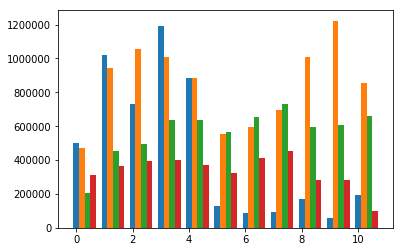

In [30]:
# Trying to plot a grouped bar chart

N = 11

fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.2         # the width of the bars
p1 = ax.bar(ind, df_actions_year.fillna('log only').query('FilterActions=="log only"')['Freq'], width, bottom=0)
p2 = ax.bar(ind + width, df_actions_year.fillna('log only').query('FilterActions=="tag"')['Freq'], width, bottom=0)
p3 = ax.bar(ind + 2*width, df_actions_year.fillna('log only').query('FilterActions=="warn"')['Freq'], width, bottom=0)
p4 = ax.bar(ind + 3*width, df_actions_year.fillna('log only').query('FilterActions=="disallow"')['Freq'], width, bottom=0)
p5 = ax.bar(ind + 4*width, df_actions_year.fillna('log only').query('FilterActions=="disallow,tag"')['Freq'], width, bottom=0)
p6 = ax.bar(ind + 5*width, df_actions_year.fillna('log only').query('FilterActions=="blockautopromote,tag"')['Freq'], width, bottom=0)
p7 = ax.bar(ind + 6*width, df_actions_year.fillna('log only').query('FilterActions=="blockautopromote"')['Freq'], width, bottom=0)
p8 = ax.bar(ind + 7*width, df_actions_year.fillna('log only').query('FilterActions=="aftv5flagabuse"')['Freq'], width, bottom=0)

plt.xlabel('actions')
plt.xticks(rotation='20')
plt.ylabel('Num filters')
ax.set_title('Scores by group and gender')
ax.set_xticks(ind + 8*width / 9)
ax.set_xticklabels(('2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'))

ax.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0], p7[0], p8[0]), ('log only', 'tag', 'warn', 'disallow', 'disallow,tag', 'blockautopromote,tag', 'blockautopromote', 'aftv5flagabuse'))
ax.autoscale_view()
plt.show()

In [8]:
# investigate actions other than "log only", "tag", "warn", "disallow"
collections.Counter(list(df_actions['FilterActions'].fillna('log only'))).most_common()

[('log only', 121),
 ('disallow', 121),
 ('tag', 121),
 ('warn', 121),
 ('disallow,tag', 63),
 ('blockautopromote', 21),
 ('aftv5flagabuse', 5),
 ('blockautopromote,tag', 4)]

So, apparently 'aftv5flagabuse' was deprecated as an action at some point: "Deleting, AFTv5 removed from WMF wikis --Legoktm 03/03/13" see https://en.wikipedia.org/wiki/Special:AbuseFilter/history/472/diff/prev/12164

In [14]:
df_actions.fillna('log only').query('FilterActions!="disallow" & FilterActions!="tag" & FilterActions!="log only" & FilterActions!="warn" & FilterActions!="disallow,tag"')

,LogMonth,FilterActions,Freq
367,2012-09-01,aftv5flagabuse,4
372,2012-08-01,aftv5flagabuse,1667
373,2012-08-01,blockautopromote,1
378,2012-07-01,aftv5flagabuse,2589
379,2012-07-01,blockautopromote,3
384,2012-06-01,aftv5flagabuse,1330
385,2012-06-01,blockautopromote,6
390,2012-05-01,aftv5flagabuse,165
391,2012-05-01,blockautopromote,14
396,2012-04-01,blockautopromote,13


In [30]:
mask2018 = (df_actions['LogMonth'] >= '2018-01-01') & (df_actions['LogMonth'] < '2019-01-01')
actions_2018 = df_actions.loc[mask2018]
print (actions_2018)

     LogMonth FilterActions   Freq
14 2018-12-01           NaN  83958
15 2018-12-01      disallow  33417
16 2018-12-01  disallow,tag      6
17 2018-12-01           tag  76257
18 2018-12-01          warn  32649
19 2018-11-01           NaN  83866
20 2018-11-01      disallow  43244
21 2018-11-01  disallow,tag      5
22 2018-11-01           tag  86062
23 2018-11-01          warn  40056
24 2018-10-01           NaN  87070
25 2018-10-01      disallow  38163
26 2018-10-01  disallow,tag      8
27 2018-10-01           tag  86140
28 2018-10-01          warn  45057
29 2018-09-01           NaN  88941
30 2018-09-01      disallow  27452
31 2018-09-01  disallow,tag      1
32 2018-09-01           tag  75443
33 2018-09-01          warn  38517
34 2018-08-01           NaN  97404
35 2018-08-01      disallow  22387
36 2018-08-01  disallow,tag      2
37 2018-08-01           tag  69333
38 2018-08-01          warn  26919
39 2018-07-01           NaN  93867
40 2018-07-01      disallow  18885
41 2018-07-01  disal

15    33417
20    43244
25    38163
30    27452
35    22387
40    18885
45    21996
50    30660
55    30991
60    34215
65    32644
70    32164
Name: Freq, dtype: int64

ValueError: shape mismatch: objects cannot be broadcast to a single shape

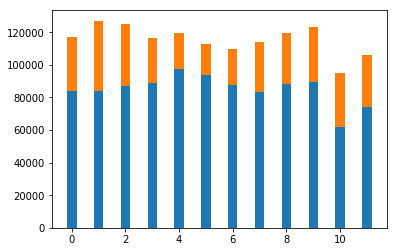

In [51]:
ind = np.arange(12)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence
y_offset = np.zeros(len(ind))

for a in actions_2018['FilterActions'].fillna('log_only').unique():
    ac = actions_2018.fillna('log_only').query('FilterActions==@a')
    plt.bar(ind, ac['Freq'], width, bottom=y_offset)
    y_offset = y_offset + ac['Freq']

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

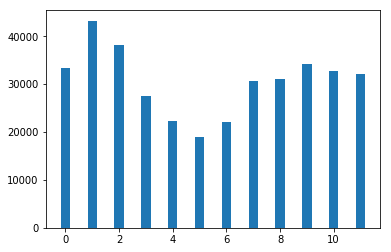

In [36]:
disallow = actions_2018.query('FilterActions=="disallow"')
disallow_tag = actions_2018.query('FilterActions=="disallow,tag"')
tag = actions_2018.query('FilterActions=="tag"')
warn = actions_2018.query('FilterActions=="warn"')
log = actions_2018.fillna('log_only').query('FilterActions=="log_only"')


ind = np.arange(12)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

'''
p1 = plt.bar(ind, disallow['Freq'], width)
p2 = plt.bar(ind, disallow_tag['Freq'], width, bottom=disallow['Freq'])
p3 = plt.bar(ind, tag['Freq'], width, bottom=(disallow['Freq']+disallow_tag['Freq']))
p4 = plt.bar(ind, warn['Freq'], width, bottom=(disallow['Freq']+disallow_tag['Freq']+tag['Freq']))
p5 = plt.bar(ind, log['Freq'], width, bottom=(disallow['Freq']+disallow_tag['Freq']+tag['Freq']+warn['Freq']))

plt.ylabel('Frequency of edit filter actions')
plt.title('Edit filter actions per month')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0]), ('disallow', 'disallow, tag', 'tag', 'warn', 'log only'))
'''



plt.show()


In [5]:
# Which editors' actions triggered a filter
df_ed_actions = pd.read_csv("quarry-34050-which-actions-triggered-an-abuse-filter-en-wiki-run346498.csv", sep=',')
collections.Counter(list(df_ed_actions['EditorActions'])).most_common()


[('createaccount', 121),
 ('edit', 121),
 ('move', 121),
 ('delete', 61),
 ('autocreateaccount', 58),
 ('upload', 35),
 ('feedback', 24),
 ('gatheredit', 11),
 ('moodbar', 11),
 ('stashupload', 2)]

In [23]:
# Which editors' actions triggered a filter over time
df_ed_actions['LogMonth'] = pd.to_datetime(df_ed_actions['LogMonth'], format="%Y%m")
df_ed_actions

#TODO what's the difference between "createaccount" and "autocreateaccount"?

,LogMonth,EditorActions,Freq
0,2019-03-01,autocreateaccount,47
1,2019-03-01,createaccount,4780
2,2019-03-01,delete,5
3,2019-03-01,edit,37950
4,2019-03-01,move,84
5,2019-03-01,upload,3
6,2019-02-01,autocreateaccount,454
7,2019-02-01,createaccount,25204
8,2019-02-01,delete,5
9,2019-02-01,edit,210488


In [ ]:
# TODO multi line chart

In [3]:
# In which namespaces did a filter trigger occur?
df_namespaces = pd.read_csv("quarry-34072-edits-in-which-namespaces-actions-triggered-an-abuse-filter-en-wiki-run346852.csv", sep=',')
df_namespaces

,LogMonth,Namespace,Freq
0,201903,-1,5177
1,201903,0,37653
2,201903,1,200
3,201903,2,1636
4,201903,3,604
5,201903,4,159
6,201903,5,13
7,201903,6,7
8,201903,10,98
9,201903,11,8


## Manual tags

In [39]:
manual_tags = df['manual_tags']
manual_tags_list = [x.split(", ") for x in list(manual_tags)]
all_tags = flatten(manual_tags_list)

print(collections.Counter(all_tags).most_common())

[('vandalism', 263), ('vandalism?', 162), ('unknown', 71), ('good_faith?', 63), ('misc', 59), ('sockpuppetry', 59), ('good_faith', 48), ('test', 43), ('spam?', 41), ('long_term_abuse', 35), ('sockpuppetry?', 35), ('harassment?', 31), ('harassment', 24), ('abuse?', 21), ('biased_pov', 17), ('spam', 17), ('biased_pov?', 15), ('unclear', 14), ('bad_style', 13), ('bad_style?', 12), ('bug?', 10), ('wiki_policy?', 9), ('long_term_abuse?', 9), ('misc?', 8), ('seo', 8), ('politically_motivated?', 8), ('maintenance', 7), ('trolling?', 7), ('maintenance?', 6), ('personal_attacks', 6), ('bug', 5), ('vandalbot', 5), ('page_move_vandalism', 5), ('silly_vandalism', 5), ('lazyness', 4), ('seo?', 4), ('test?', 4), ('hoaxing?', 4), ('personal_attacks?', 4), ('edit_warring?', 3), ('copyright', 3), ('image_vandalism', 3), ('talk_page_vandalism', 3), ('page_move_vandalism?', 3), ('conflict_of_interest', 3), ('stockbrocker_vandalism', 3), ('copyright?', 2), ('vandalbot?', 2), ('religious_vandalism?', 2), (

('vandalism', 263),
('vandalism?', 162),
  ('spam?', 41),
  ('spam', 17),
  ('vandalbot', 5),
  ('vandalbot?', 2),
  ('page_move_vandalism', 5),
  ('page_move_vandalism?', 3),
  ('silly_vandalism', 5),
  ('silly_vandalism?', 2),
  ('trolling?', 7),
  ('hoaxing?', 4),
  ('hoaxing', 2),
  ('copyright', 3),
  ('copyright?', 2),
  ('image_vandalism', 3),
  ('talk_page_vandalism', 3),
  ('template_vandalism?', 1),
  ('template_vandalism', 1),
  ('template_spam', 2),
  ('link_vandalism?', 1),
  ('abuse_of_tags_vandalism?', 1),
  ('avoidant_vandalism', 1),
  ('avoidant_vandalism?', 1),
  ('username_vandalism?', 1),

('prank', 1)

('phishing?', 1),
('malware?', 1),
('malware', 1),

('guideline_vio?', 1),

('religious_vandalism?', 3),
('politically_motivated?', 8),
('politically_motivated', 2),

('sockpuppetry', 59),
('sockpuppetry?', 35),
('long_term_abuse', 35),
('long_term_abuse?', 9),
('abuse', 1),
('abuse?', 21),
('harassment?', 31),
('harassment', 24),
('doxxing?', 2),
('personal_attacks', 6),
('personal_attacks?', 4),
('impersonation', 1),
('not_polite', 1),

('biased_pov', 17),
('biased_pov?', 15),

('conflict_of_interest', 3),
('stockbrocker_vandalism', 3),
('self_promotion?', 2),
('conflict_of_interest?', 1),
('self_promotion', 1),

('seo', 8),
('seo?', 4),

('bad_style', 13),
('bad_style?', 12),
('edit_warring?', 3),

('good_faith?', 63),
('good_faith', 48),

('lazyness', 4),

('maintenance', 7),
('maintenance?', 5),
('maintenance? ', 1),

('bug', 5),
('bug?', 10),
('wiki_policy?', 9),

('test', 43),
('test?', 4),

('unknown', 71),
('misc', 59),
('misc?', 8),
('unclear', 14),

In [19]:
# manual tags per year
df_logs_2009 = pd.read_csv("data/log-entries-yearly/2009.csv", sep=',')
df_ids_manual_tags = df[['af_id', 'manual_tags']]
df_2009_tags = df_logs_2009.join(df_ids_manual_tags.set_index('af_id'), on='afl_filter', how='inner')
df_2009_tags

,afl_filter,count(*),manual_tags
0,135,175455,vandalism
1,30,160302,"good_faith, vandalism"
2,61,147377,good_faith
3,18,133640,lazyness
4,3,95916,good_faith
5,172,89710,good_faith
6,50,88827,"vandalism, good_faith"
7,98,80434,good_faith
8,65,74098,"vandalism, good_faith?"
9,132,68607,"vandalism, good_faith"


In [15]:
df_2009_tags['manual_tags']
tags_list_2009 = flatten([x.split(", ") for x in list(df_2009_tags['manual_tags'])])
# would be interesting to multiply with hitcount

print(collections.Counter(tags_list_2009).most_common())

[('vandalism', 66), ('vandalism?', 37), ('good_faith?', 24), ('good_faith', 21), ('misc', 18), ('sockpuppetry', 10), ('unknown', 10), ('test', 9), ('abuse?', 7), ('spam?', 6), ('harassment', 5), ('harassment?', 5), ('sockpuppetry?', 5), ('biased_pov?', 4), ('bad_style', 4), ('politically_motivated?', 3), ('maintenance', 3), ('personal_attacks?', 3), ('page_move_vandalism?', 3), ('biased_pov', 2), ('seo', 2), ('misc?', 2), ('copyright?', 2), ('long_term_abuse', 2), ('unclear', 2), ('wiki_policy?', 2), ('hoaxing?', 2), ('silly_vandalism', 2), ('spam', 2), ('bug?', 2), ('doxxing?', 2), ('lazyness', 1), ('bad_style?', 1), ('seo?', 1), ('personal_attack', 1), ('maintenance?', 1), ('trolling?', 1), ('religious_vandalism?', 1), ('template_vandalism?', 1), ('link_vandalism?', 1), ('politically_motivated', 1), ('guideline_vio?', 1), ('silly_vandalism?', 1), ('template_spam', 1), ('self_promotion?', 1), ('avoidant_vandalism?', 1), ('personal_attacks', 1), ('malware', 1)]


### Combine manual tags with filter actions

In [18]:
# What are the actions and tags of active public filters
active_public = df.query('af_hidden==0 and af_enabled==1').sort_values(by=['af_actions'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(active_public[['af_id', 'af_actions', 'manual_tags']].fillna(''))


     af_id         af_actions                            manual_tags
653    897           disallow                        spam, vandalbot
67     803           disallow                  vandalism, good_faith
41      12           disallow                              vandalism
37     320           disallow                              vandalism
499    694           disallow                             good_faith
99     782           disallow                                   misc
22     260           disallow                              vandalism
54     365           disallow                              vandalism
130    784           disallow                              vandalism
19      46           disallow                              vandalism
171    860           disallow                              vandalism
110    554           disallow                seo?, vandalism?, spam?
47     680           disallow                             good_faith
470    843           disallow     

In [5]:
#all ids of active public filters set to disallow and labeled 'good_faith'
active_public[active_public['af_actions'].fillna('').str.contains('disallow') & active_public['manual_tags'].fillna('').str.contains('good_faith')]

,Unnamed: 0,af_id,af_hidden,af_global,af_enabled,af_deleted,af_throttled,af_group,af_timestamp,af_actions,af_hit_count,af_public_comments,manual_tags,notes
47,47,680,0,0,1,0,0,default,20181023195329,disallow,95242,Adding emoji unicode characters,good_faith,NaN
67,67,803,0,0,1,0,0,default,20181023223916,disallow,46756,Prevent new users from editing other's user pages,"vandalism, good_faith",NaN
271,271,642,0,0,1,0,0,default,20181023194832,disallow,712,OTRS template added by non-OTRS member (global),good_faith?,from comments: “This filter is easy to subvert...
499,499,694,0,0,1,0,0,default,20181023223653,disallow,74,Moves to or from the Module namespace,good_faith,“These types of moves don't do what users expe...


Upon second inspection (looking at https://en.wikipedia.org/wiki/Special:AbuseLog), edits targeted by filter with id 680 (adding unicode emojis) seem to be vandalism in their vast majority.

Filter 803 seems to be labeled accurately on the other hand. There are a lot of personal insults in these edits, but there are also some that look as if the user themselves wanted to edit their own page but forgot to log in (so they're editing from an IP).

The other two filters seem to be labeled somewhat reasonably and they are set to "disallow" since the intended/expected effect of the action difers from the real one and since they're disruptive.

### Manual tags 2nd labeling

In [13]:
manual_tags_2nd = df_2nd['manual_tags']
all_tags_2nd = flatten([x.split(", ") for x in list(manual_tags_2nd)])
all_tags_2nd_counts = collections.Counter(all_tags_2nd).most_common()
print(all_tags_2nd_counts)

[('hidden_vandalism', 333), ('sockpuppetry', 64), ('spam', 43), ('long_term_abuse', 43), ('test', 36), ('silly_vandalism', 26), ('general_vandalism', 25), ('general_tracking', 25), ('personal_attacks', 24), ('good_faith_template', 23), ('wiki_policy', 19), ('profanity_vandalism', 18), ('talk_page_vandalism', 17), ('good_faith', 15), ('good_faith_deletion', 14), ('unclear', 13), ('trolling', 13), ('hoaxing', 12), ('good_faith_wiki_syntax', 12), ('bot_vandalism', 12), ('politically_motivated', 12), ('image_vandalism', 12), ('page_move_vandalism', 11), ('good_faith_refs', 10), ('good_faith_article_creation', 10), ('bug', 9), ('bad_style', 8), ('template_vandalism', 8), ('good_faith_test_edits', 7), ('avoidant_vandalism', 7), ('link_vandalism', 7), ('self_promotion', 6), ('conflict_of_interest', 6), ('harassment', 6), ('doxxing', 5), ('username_vandalism', 4), ('good_faith_redirect', 4), ('good_faith_move', 4), ('impersonation', 4), ('not_polite', 3), ('good_faith_edit_summary', 3), ('copy

Ok.
So there are still the majority of filters are hidden filters for which no more precise labeling was feasible; (sounds plausible, 2/3 of all filters are hidden; half of them could be labeled with smth more specific as it seems).
The majority of the "sockpuppetry" filters are probably also hidden, same goes for "long_term_abuse"

In [10]:
len(all_tags_2nd) # verify every filter is labeled with exactly one label

954

In [12]:
# What are the actions and tags of active public filters
active_public_2nd = df_2nd.query('af_hidden==0 and af_enabled==1').sort_values(by=['af_actions'])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(active_public_2nd[['af_id', 'af_actions', 'manual_tags']].fillna('log only'))


     af_id         af_actions                    manual_tags
653    897           disallow                  bot_vandalism
67     803           disallow               personal_attacks
41      12           disallow            profanity_vandalism
37     320           disallow            profanity_vandalism
499    694           disallow            page_move_vandalism
99     782           disallow                        unclear
22     260           disallow            profanity_vandalism
54     365           disallow              general_vandalism
130    784           disallow              general_vandalism
19      46           disallow            profanity_vandalism
171    860           disallow                silly_vandalism
110    554           disallow                           spam
47     680           disallow              general_vandalism
470    843           disallow          politically_motivated
3      384           disallow            profanity_vandalism
234    892           dis

In [54]:
# An auxiliery assignment of manual tags to their corresponding clusters
clusters = {}

vandalism = ['bot_vandalism', 'page_move_vandalism', 'image_vandalism', 'talk_page_vandalism', 'template_vandalism', \
'link_vandalism', 'avoidant_vandalism', 'username_vandalism', 'silly_vandalism', 'trolling', 'hoaxing', 'prank', \
'profanity_vandalism', 'religiously_motivated', 'politically_motivated', 'general_vandalism']

for i in vandalism:
    clusters[i] = 'vandalism'

hardcore_vandalism = ['sockpuppetry', 'long_term_abuse', 'abuse', 'harassment', 'doxxing', 'personal_attacks', \
'impersonation', 'not_polite', 'hidden_vandalism']

for i in hardcore_vandalism:
    clusters[i] = 'hardcore_vandalism'

spam = ['spam', 'phishing', 'malware']

for i in spam:
    clusters[i] = 'spam'

disruptive = ['copyright_violation', 'bad_style', 'lazyness', 'edit_warring', 'wiki_policy', 'guideline_vio']

for i in disruptive:
    clusters[i] = 'disruptive'

pov = ['biased_pov', 'conflict_of_interest', 'self_promotion', 'seo']

for i in pov:
    clusters[i] = 'pov'
    
good_faith = ['good_faith', 'good_faith_refs', 'good_faith_deletion', 'good_faith_orthography', 
              'good_faith_article_creation', 'good_faith_external_resources', 'good_faith_template', \
              'good_faith_wiki_syntax', 'good_faith_test_edits', 'good_faith_edit_summary', 'good_faith_revert', \
              'good_faith_wiki_links', 'good_faith_userpage', 'good_faith_redirect', 'good_faith_html', \
              'good_faith_categories', 'good_faith_move', 'good_faith_image', 'good_faith_edits']

for i in good_faith:
    clusters[i] = 'good_faith'
    
maintenance = ['bug', 'test', 'general_maintenance', 'general_tracking']

for i in maintenance:
    clusters[i] = 'maintenance'
    
unknown = ['unknown', 'misc', 'unclear']

for i in unknown:
    clusters[i] = 'unknown'
    
clusters

{'bot_vandalism': 'vandalism',
 'page_move_vandalism': 'vandalism',
 'image_vandalism': 'vandalism',
 'talk_page_vandalism': 'vandalism',
 'template_vandalism': 'vandalism',
 'link_vandalism': 'vandalism',
 'avoidant_vandalism': 'vandalism',
 'username_vandalism': 'vandalism',
 'silly_vandalism': 'vandalism',
 'trolling': 'vandalism',
 'hoaxing': 'vandalism',
 'prank': 'vandalism',
 'profanity_vandalism': 'vandalism',
 'religiously_motivated': 'vandalism',
 'politically_motivated': 'vandalism',
 'general_vandalism': 'vandalism',
 'sockpuppetry': 'hardcore_vandalism',
 'long_term_abuse': 'hardcore_vandalism',
 'abuse': 'hardcore_vandalism',
 'harassment': 'hardcore_vandalism',
 'doxxing': 'hardcore_vandalism',
 'personal_attacks': 'hardcore_vandalism',
 'impersonation': 'hardcore_vandalism',
 'not_polite': 'hardcore_vandalism',
 'hidden_vandalism': 'hardcore_vandalism',
 'spam': 'spam',
 'phishing': 'spam',
 'malware': 'spam',
 'copyright_violation': 'disruptive',
 'bad_style': 'disrupt

/home/lus/uni/ma-arbeit-filters/src/env3/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'vandalism' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/lus/uni/ma-arbeit-filters/src/env3/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'hardcore_vandalism' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/home/lus/uni/ma-arbeit-filters/src/env3/lib/python3.6/site-packages/matplotlib/legend.py:798: UserWarning: Legend does not support 'spam' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding

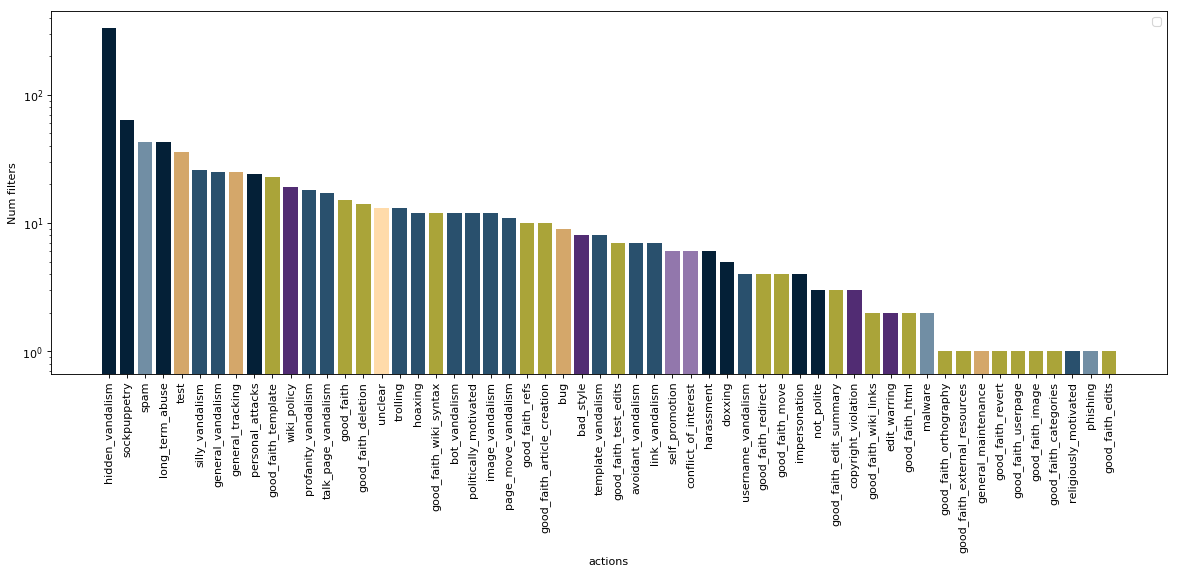

In [66]:
fig, ax = plt.subplots(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')

tags_2nd = [x[0] for x in all_tags_2nd_counts]
counts_2nd = [x[1] for x in all_tags_2nd_counts]

'''
colormap={'vandalism':'#462E74',
          'hardcore_vandalism':'#18063A',
          'spam':'#665091',
          'disruptive':'#7F488C',
          'pov':'#9E72A8',
          'good_faith':'#737D15',
          'maintenance':'#AA9B39',
          'unknown':'#D4C76A'}
'''

colormap={'vandalism':'#29506D',
          'hardcore_vandalism':'#042037',
          'spam':'#718EA4',
          'disruptive':'#512C73',
          'pov':'#9277AC',
          'good_faith':'#AAA439',
          'maintenance':'#D4A76A',
          'unknown':'#FFDBAA'}

plt.yscale("log")
plt.xlabel('actions')
plt.xticks(rotation='90')
plt.ylabel('Num filters')
plt.bar(tags_2nd, counts_2nd, color=[colormap[clusters[x]] for x in tags_2nd])
#ax.legend((p1[0], p2[0]), ('Men', 'Women'))
ax.legend(colormap.keys(), colormap.values())
#plt.xticks(matplotlib.dates.date2num(df_hits['LogMonth']))
#plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 60)
#plt.grid(color='0.7', linestyle='-', linewidth=0.2)

plt.show()



In [ ]:
# TODO Plot of parent categories!

In [ ]:
#TODO Plot (manual tags)*(hit count) for all filters

In [20]:
# manual tags per year
df_logs_2009 = pd.read_csv("data/log-entries-yearly/2009.csv", sep=',')
df_2nd_ids_manual_tags = df_2nd[['af_id', 'manual_tags']]
df_2009_tags_2nd = df_logs_2009.join(df_2nd_ids_manual_tags.set_index('af_id'), on='afl_filter', how='inner')
df_2009_tags_2nd

,afl_filter,count(*),manual_tags
0,135,175455,silly_vandalism
1,30,160302,good_faith_deletion
2,61,147377,good_faith_refs
3,18,133640,good_faith_test_edits
4,3,95916,good_faith_deletion
5,172,89710,good_faith_deletion
6,50,88827,not_polite
7,98,80434,good_faith_article_creation
8,65,74098,bad_style
9,132,68607,good_faith_deletion


In [ ]:
#TODO Plot a per year (manual tags)*(hit count) for all filters

## Edit filter editors

The following snippet determines the edit filter managers who were the last to modify a filter. It also computes how many filters have each manager modified (as last modifier).

In [89]:
raw_df = pd.read_csv("quarry-32518-all-filters-sorted-num-hits.csv", sep=',')
editors = raw_df['af_user_text']
print (editors.unique())
print (len(editors.unique()))
print (raw_df['af_user_text'].value_counts())

['Zzuuzz' 'Dragons flight' 'This, that and the other' 'MusikAnimal' 'Crow'
 'Samtar' 'Xaosflux' 'King of Hearts' 'Amorymeltzer' 'Samwalton9'
 'Biblioworm' 'NawlinWiki' 'MER-C' 'Rich Farmbrough' 'Galobtter'
 'Cenarium' 'Ruslik0' 'Legoktm' 'Od Mishehu' 'BU Rob13' 'Prodego'
 'Timotheus Canens' 'Oshwah' 'The Earwig' 'The Anome' 'Kww' 'Beetstra'
 'Reaper Eternal' 'BethNaught' 'Mlitn' 'Cyp' "There'sNoTime" 'Kuru'
 'Shirik' 'Xeno' 'Kaldari' 'Kingpin13' 'DoRD' 'Elockid' 'Ritchie333'
 'Maxim' 'Ryan Kaldari (WMF)' 'Cyberpower678' 'GB fan' 'Jackmcbarn' 'L235'
 'Smalljim' 'Materialscientist' 'Someguy1221' 'Billinghurst' 'Tedder'
 'Gogo Dodo' 'Triplestop' 'Darkwind' 'Amalthea' 'Slakr' 'Scottywong'
 'Mr.Z-man' 'SQL' 'Avraham' 'NuclearWarfare' 'OverlordQ' 'Nihiltres'
 'Hersfold' 'Mifter' 'Chris G' 'EdoDodo' 'Nakon' 'Werdna' 'Wknight94'
 'DMacks' 'East718' 'Georgewilliamherbert' 'Mindmatrix' 'Rschen7754'
 'Lustiger seth' "Chris G's Test Account"]
77
MusikAnimal                 249
King of Hearts      

This is a list of all users in the edit filter manager group from (https://en.wikipedia.org/w/index.php?title=Special:ListUsers/abusefilter ) who are not at the same time administrators (11 out of 154):

* -revi talk contribs‏‎ (edit filter manager, account creator, extended confirmed user, pending changes reviewer, rollbacker, template editor) (Created on 9 October 2010 at 11:44)
* Chriswaterguy talk contribs‏‎ (edit filter manager, extended confirmed user, rollbacker) (Created on 31 August 2005 at 06:44)
* Crow talk contribs‏‎ (edit filter manager, extended confirmed user, page mover, new page reviewer, pending changes reviewer) (Created on 28 September 2013 at 22:30)
* Eloquence talk contribs‏‎ (edit filter manager, extended confirmed user) (Created on 8 December 2001 at 01:47)
* Hoo man talk contribs‏‎ (edit filter manager, extended confirmed user, pending changes reviewer, rollbacker) (Created on 8 June 2009 at 19:54)
* Jasper Deng talk contribs‏‎ (edit filter manager, extended confirmed user, pending changes reviewer, rollbacker) (Created on 4 May 2008 at 00:40)
* Kaldari talk contribs‏‎ (edit filter manager, autopatrolled, extended confirmed user, file mover, new page reviewer, pending changes reviewer, rollbacker) (Created on 19 April 2004 at 23:46)
* Petrb talk contribs‏‎ (edit filter manager, autopatrolled, extended confirmed user, file mover, IP block exempt, pending changes reviewer, rollbacker) (Created on 14 October 2010 at 14:03)
* Rich Farmbrough talk contribs‏‎ (edit filter manager, autopatrolled, extended confirmed user, file mover, pending changes reviewer, rollbacker, template editor) (Created on 2 May 2004 at 20:34)
* Suffusion of Yellow talk contribs‏‎ (edit filter manager, extended confirmed user, pending changes reviewer, rollbacker) (Created on 15 October 2009 at 06:33)
* This, that and the other talk contribs‏‎ (edit filter manager, extended confirmed user, new page reviewer, rollbacker, template editor) (Created on 19 April 2007 at 07:33)

There are also significant overlaps between members of the BAG and edit filter managers.

TODO
It would be very interesting to check how many of the edit filter managers are also bot operators (and in general, how many bot operators are there). Not sure whether there is an easy way to know this

## Vandalism

We may be interested in how the notion of vandalism changed over the years. For this an inquiry into which filters have "vandalism" in their public description (and were tagged as "vandalism") and what they do may be interesting.

Archive for now, the question in not very cs-y

## Potential harassment

In [9]:
df_harassment_tagged = df[df['manual_tags'].fillna('').str.contains('harassment')]

print(df_harassment_tagged[['af_id', 'af_hidden', 'af_public_comments', 'manual_tags']])

     af_id  af_hidden                                 af_public_comments  \
14     189          0                             BLP vandalism or libel   
16     380          1                               Multiple obscenities   
23     686          0    IP adding possibly unreferenced material to BLP   
42     247          1                          Adding emails in articles   
45      11          0                                You/He/She/It sucks   
53     339          0  Claims of homosexuality, bisexuality, or trans...   
72       9          0       Personal attacks by unregistered or new user   
74     466          1                     Userspace & talk page spamming   
93     460          0                               Feedback: Foul words   
136    478          1                                    Talk page abuse   
148     97          0                       Personal attacks by new user   
150    294          1                                   Personal attacks   
154    463  

Another idea would be to classify filters according to the namespaces they cover. A filter targeting the talk/user name spaces may be indicative of dealing with personal attacks or harassment.

In [29]:
namespaces = df_origin[df_origin['af_pattern'].fillna('').str.contains('namespace')]
non_article_spaces = namespaces[~namespaces['af_pattern'].fillna('').str.contains('namespace == 0') & ~namespaces['af_pattern'].fillna('').str.contains('namespace = 0') & ~namespaces['af_pattern'].fillna('').str.contains('namespace==0')]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print (non_article_spaces[['af_id', 'af_public_comments']])

     af_id                                 af_public_comments
37     320                               "Your mom" Vandalism
40     631                          Extraneous toolbar markup
55      65                               Excessive whitespace
61      33        Talk page blanking by unregistered/new user
67     803  Prevent new users from editing other's user pages
70     368  Making large changes when marking the edit as ...
81     167       Botched submissions to Articles for creation
83     613                                 Signing in article
85     627  Promotional text added by user to draft in own...
94      59   New user removing templates on image description
95     174                     New user removing XfD template
101    602         Arbitration discretionary sanctions alerts
107    420           Large removal of talk page content by IP
109    733  New user creating a page in someone else's use...
134    878                     New user removing COI template
157    8

Following filters seem to be potentially targeting harassment: (manually kick out all that obviously do not have anything to do with harassment)

    af_id                                 af_public_comments
    67     803  Prevent new users from editing other's user pages
    101    602         Arbitration discretionary sanctions alerts
    109    733  New user creating a page in someone else's use...
    274     99                 Edits to an other user's userspace
    285    123                New users moving other users' pages
    329    212  New user placing comments without a header on ...
    424    168          Non-admins responding to unblock requests
    619      6           Users editing editnotices of other users
    643     15                          Discussion page vandalism
    730    207              Non-admins reviewing unblock requests
    863     67                    Sockpuppetry at AfD discussions
    866    329                                     SPI disruption
    921    427                  Possible Emergency Reponse Needed

## Code snippets that may come in handy

In [36]:
# make a data frame out of list
ten_tags = manual_tags.head(10).str.split(", ", n = 1, expand = True).apply(pd.Series)
ten_tags = ten_tags.rename(columns = lambda x : 'tag_' + str(x))
ten_tags

0               good_faith
1                vandalism
2                vandalism
3                vandalism
4               good_faith
5               good_faith
6     good_faith, lazyness
7    vandalism, good_faith
8               good_faith
9               good_faith
Name: manual_tags, dtype: object


,tag_0,tag_1
0,good_faith,None
1,vandalism,None
2,vandalism,None
3,vandalism,None
4,good_faith,None
5,good_faith,None
6,good_faith,lazyness
7,vandalism,good_faith
8,good_faith,None
9,good_faith,None


In [88]:
raw_df.groupby('af_user_text').count()

MusikAnimal                 249
King of Hearts               91
Zzuuzz                       81
Rich Farmbrough              61
Ruslik0                      59
Prodego                      45
Samwalton9                   34
Cenarium                     32
NawlinWiki                   28
Xaosflux                     27
Reaper Eternal               25
Shirik                       23
Beetstra                     16
Dragons flight               15
Crow                         13
Legoktm                      11
Samtar                        9
The Anome                     9
Cyp                           7
BethNaught                    6
Ryan Kaldari (WMF)            5
BU Rob13                      5
Oshwah                        5
Kww                           5
Od Mishehu                    5
There'sNoTime                 5
Elockid                       4
Kuru                          4
Materialscientist             4
Mlitn                         4
                           ... 
This, th